In [1]:
!pip install opencv-python torch torchvision ultralytics ipywidgets pillow GitPython --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 910.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.0/869.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00


# Video streaming image detection

In [2]:
import cv2
from google.colab.patches import cv2_imshow

<IPython.core.display.Javascript object>

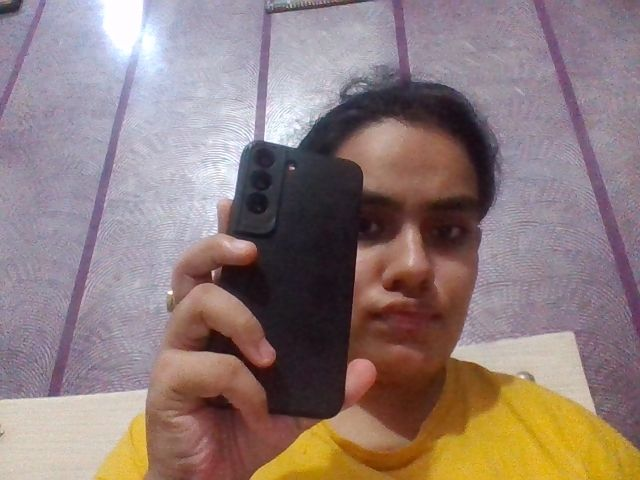

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Take a photo
image_file = take_photo()

# Read and display the image
image = cv2.imread(image_file)
cv2_imshow(image)

In [5]:
from ultralytics import YOLO
import torch
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the YOLO model
model = YOLO('yolov5s.pt')  # Load the smallest YOLOv5 model

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 367MB/s]


In [6]:
# Assuming we've already taken a photo using the previous code
image_file = 'test_1.jpeg'

# Read the image
image = cv2.imread(image_file)

# Perform object detection
results = model(image)

# Process the results
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy().astype(int)
    classes = result.boxes.cls.cpu().numpy().astype(int)
    confidences = result.boxes.conf.cpu().numpy()

    # Draw bounding boxes and labels on the image
    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = box
        label = f'{model.names[cls]} {conf:.2f}'
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with detections
cv2_imshow(image)

WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 734.0ms
image 2/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 2 ties, 511.6ms
Speed: 10.7ms preprocess, 622.8ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)


AttributeError: 'NoneType' object has no attribute 'clip'

In [7]:
import cv2
import torch
from ultralytics import YOLO
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import io
from PIL import Image as PILImage
import ipywidgets as widgets
import time

# Load the YOLO model
model = YOLO('yolov5s.pt')

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    return PILImage.open(io.BytesIO(binary))

def process_image(image):
    # Convert PIL Image to OpenCV format
    open_cv_image = np.array(image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    # Perform object detection
    results = model(open_cv_image)

    # Process the results
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy().astype(int)
        classes = result.boxes.cls.cpu().numpy().astype(int)
        confidences = result.boxes.conf.cpu().numpy()

        # Draw bounding boxes and labels on the image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            label = f'{model.names[cls]} {conf:.2f}'
            cv2.rectangle(open_cv_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(open_cv_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return PILImage.fromarray(open_cv_image[:, :, ::-1])

# Create a widget to display the video stream
image_widget = widgets.Image(format='jpeg', width=640, height=480)
display(image_widget)

# Main loop for continuous capture and detection
try:
    while True:
        # Capture frame
        frame = take_photo()

        # Process frame
        processed_frame = process_image(frame)

        # Convert PIL Image to JPEG bytes
        img_byte_arr = io.BytesIO()
        processed_frame.save(img_byte_arr, format='JPEG')
        img_byte_arr = img_byte_arr.getvalue()

        # Update widget with new frame
        image_widget.value = img_byte_arr

        # Add a small delay to control the frame rate
        time.sleep(0.1)
except KeyboardInterrupt:
    print("Stopped")

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



Image(value=b'', format='jpeg', height='480', width='640')

<IPython.core.display.Javascript object>


0: 480x640 1 person, 376.4ms
Speed: 3.2ms preprocess, 376.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 1 book, 361.3ms
Speed: 2.4ms preprocess, 361.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 372.9ms
Speed: 3.1ms preprocess, 372.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 766.6ms
Speed: 2.5ms preprocess, 766.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 368.0ms
Speed: 3.0ms preprocess, 368.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 373.2ms
Speed: 3.2ms preprocess, 373.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 377.6ms
Speed: 4.3ms preprocess, 377.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 2 cell phones, 1 book, 364.8ms
Speed: 3.2ms preprocess, 364.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 2 cell phones, 2 books, 538.3ms
Speed: 2.8ms preprocess, 538.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 1 banana, 1 cell phone, 1 book, 370.2ms
Speed: 3.7ms preprocess, 370.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 354.8ms
Speed: 3.5ms preprocess, 354.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 360.3ms
Speed: 4.8ms preprocess, 360.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>

Stopped


# Motion detection

In [8]:
import cv2
import torch
from ultralytics import YOLO
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import io
from PIL import Image as PILImage
import ipywidgets as widgets
import time

# Load the YOLO model
try:
    model = YOLO('yolov8s.pt')
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Dictionary to store previous positions of objects
prev_positions = {}

def take_photo(filename='test_1.jpeg', quality=0.8):
    try:
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});
                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
        ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        return PILImage.open(io.BytesIO(binary))
    except Exception as e:
        print(f"Error taking photo: {e}")
        return None

def process_image(image):
    global prev_positions

    # Convert PIL Image to OpenCV format
    open_cv_image = np.array(image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    # Perform object detection
    try:
        results = model(open_cv_image)
    except Exception as e:
        print(f"Error performing object detection: {e}")
        return image

    # Process the results
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy().astype(int)
        classes = result.boxes.cls.cpu().numpy().astype(int)
        confidences = result.boxes.conf.cpu().numpy()

        # Draw bounding boxes and labels on the image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            center_y = (y1 + y2) / 2
            label = f'{model.names[cls]} {conf:.2f}'

            # Check for vertical motion
            if cls in prev_positions:
                prev_y = prev_positions[cls]
                if center_y < prev_y - 5:  # Object moved up
                    label += ' UP'
                elif center_y > prev_y + 5:  # Object moved down
                    label += ' DOWN'

            # Update position
            prev_positions[cls] = center_y

            cv2.rectangle(open_cv_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(open_cv_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return PILImage.fromarray(open_cv_image[:, :, ::-1])

# Create a widget to display the video stream
image_widget = widgets.Image(format='jpeg', width=640, height=480)
display(image_widget)

# Main loop for continuous capture and detection
try:
    while True:
        # Capture frame
        frame = take_photo()
        if frame is None:
            continue

        # Process frame
        processed_frame = process_image(frame)

        # Convert PIL Image to JPEG bytes
        img_byte_arr = io.BytesIO()
        processed_frame.save(img_byte_arr, format='JPEG')
        img_byte_arr = img_byte_arr.getvalue()

        # Update widget with new frame
        image_widget.value = img_byte_arr

        # Add a small delay to control the frame rate
        time.sleep(0.1)
except KeyboardInterrupt:
    print("Stopped")

100%|██████████| 21.5M/21.5M [00:00<00:00, 364MB/s]


Image(value=b'', format='jpeg', height='480', width='640')

<IPython.core.display.Javascript object>


0: 480x640 1 person, 423.3ms
Speed: 2.8ms preprocess, 423.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 407.1ms
Speed: 3.0ms preprocess, 407.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 632.0ms
Speed: 2.4ms preprocess, 632.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 1 cell phone, 471.2ms
Speed: 2.5ms preprocess, 471.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 398.8ms
Speed: 3.2ms preprocess, 398.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 431.9ms
Speed: 3.0ms preprocess, 431.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 627.0ms
Speed: 2.6ms preprocess, 627.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 1 cell phone, 397.4ms
Speed: 2.9ms preprocess, 397.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 2 cell phones, 404.8ms
Speed: 3.2ms preprocess, 404.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 1 umbrella, 402.1ms
Speed: 3.8ms preprocess, 402.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>


0: 480x640 1 person, 1 banana, 410.8ms
Speed: 3.1ms preprocess, 410.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


<IPython.core.display.Javascript object>

Stopped
